In [11]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

直接使用自带的数据

In [3]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [4]:
dta = sm.datasets.sunspots.load_pandas().data
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del dta["YEAR"]
print(dta.tail(15))

            SUNACTIVITY
1994-12-31         29.9
1995-12-31         17.5
1996-12-31          8.6
1997-12-31         21.5
1998-12-31         64.3
1999-12-31         93.3
2000-12-31        119.6
2001-12-31        111.0
2002-12-31        104.0
2003-12-31         63.7
2004-12-31         40.4
2005-12-31         29.8
2006-12-31         15.2
2007-12-31          7.5
2008-12-31          2.9


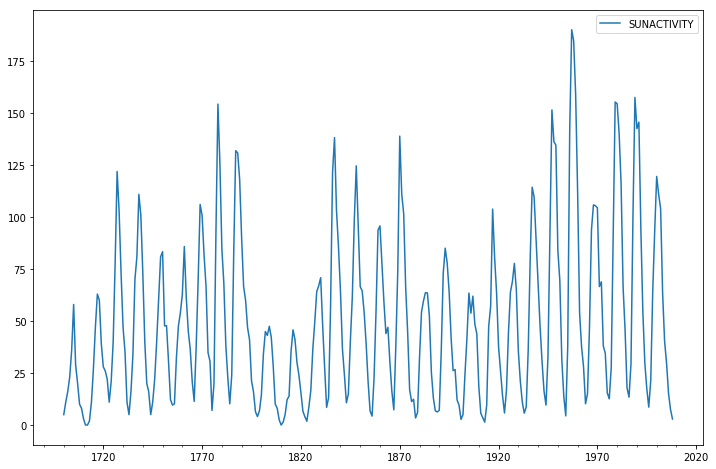

In [5]:
dta.plot(figsize=(12,8));

In [6]:
from statsmodels.graphics.tsaplots import plot_acf  #自相关图
from statsmodels.tsa.stattools import adfuller as ADF  #平稳性检测
from statsmodels.graphics.tsaplots import plot_pacf    #偏自相关图
from statsmodels.stats.diagnostic import acorr_ljungbox    #白噪声检验

#### 定阶

绘制自相关图plot_acf和偏自相关图plot_pacf，查看p, q

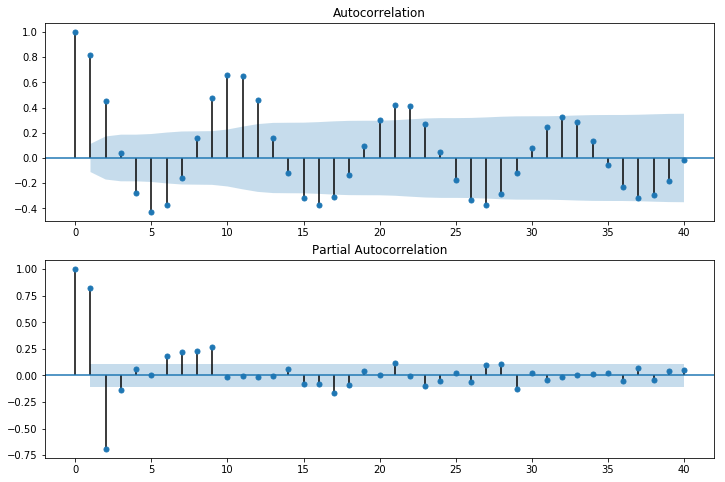

In [7]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(dta, lags=40, ax=ax2)

尝试直接使用系统拟合合适的p，q，适合不会看图设置值的人。 arma_order_select_ic中max_ar默认是5,max_ma默认是5，不会只能用默认值了。

In [13]:
import statsmodels.tsa.stattools as st
order = st.arma_order_select_ic(dta,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic']) 
order.bic_min_order

(4, 2)

把(4, 2)代入p, q

In [14]:
arma_mod30 = sm.tsa.ARMA(dta, (4, 2)).fit(disp=True) 
print(arma_mod30.aic, arma_mod30.bic, arma_mod30.hqic) 

2575.377592169541 2605.244322384723 2587.318367860033


In [23]:
print(arma_mod30.params)

const                48.951537
ar.L1.SUNACTIVITY     2.789765
ar.L2.SUNACTIVITY    -3.067824
ar.L3.SUNACTIVITY     1.477086
ar.L4.SUNACTIVITY    -0.220110
ma.L1.SUNACTIVITY    -1.648047
ma.L2.SUNACTIVITY     0.790718
dtype: float64


In [24]:
sm.stats.durbin_watson(arma_mod30.resid.values)

1.9544834556607595

D.W统计量是用来检验残差分布是否为正态分布的，因为用OLS进行回归估计是假设模型残差服从正态分布的，因此，如果残差不服从正态分布，那么，模型将是有偏的，也就是说模型的解释能力是不强的。 
D.W统计量在2左右说明残差是服从正态分布的，若偏离2太远，那么你所构建的模型的解释能力就要受影响了。
这里等到1.9544834556607595，接近2，模拟的数据残差resid服从正态分布。

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_mod30.resid.plot(ax=ax);

In [27]:
resid = arma_mod30.resid  #残差

In [28]:
stats.normaltest(resid)

NormaltestResult(statistic=39.70778338165877, pvalue=2.3854174634690103e-09)

在统计学上，你需要一个小于0.05的p值来拒绝零假设。
现在得出一个模型的拟合，要检验这个模型的有效性。采取残差白噪声检验。
原理：拟合出来的曲线的残差如果是白噪声，说明拟合曲线已经完全把原数据的特征提取出来，剩下出来的都是一些没有意义的信息，即残差为白噪声。
白噪声时间序列的定义是均值为零，方差恒定和相关性为零。 
如果你的时间序列是白噪声，那么它无法进行预测。否则，你可能可以改善这个模型。 
你可以在时间序列上使用统计数据和诊断图，用以检查它是否是白噪声。 

In [29]:
acorr_ljungbox(resid, lags=1) # p值远小于0.05，平稳非白噪声序列，反之为白噪声序列 

(array([0.01403868]), array([0.90568342]))

lbvalue 为0.01403868， pvalue 0.90568342, 远远大于0.05，说明残差为白噪声。lags还可以取各种值

In [31]:
# from IPython.display import IFrame
# IFrame("http://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html", width='100%', height=350)
acorr_ljungbox(resid, lags=4)

(array([0.01403868, 0.01403988, 2.69319022, 4.31287769]),
 array([0.90568342, 0.99300464, 0.44138579, 0.36531532]))

pvalue 远远大于0.05 ，残差是白噪声，拟合曲线已经把特征提取出来。

开始预测

In [32]:
predict_sunspots = arma_mod30.predict('1990', '2012', dynamic=True)
print(predict_sunspots)

1990-12-31    173.759218
1991-12-31    159.131254
1992-12-31    122.641940
1993-12-31     76.955586
1994-12-31     36.280603
1995-12-31     12.286533
1996-12-31     10.681380
1997-12-31     29.788525
1998-12-31     61.528963
1999-12-31     94.370365
2000-12-31    117.192303
2001-12-31    122.786203
2002-12-31    109.901378
2003-12-31     83.275891
2004-12-31     51.764738
2005-12-31     25.275056
2006-12-31     11.553667
2007-12-31     13.855740
2008-12-31     30.181165
2009-12-31     54.225883
2010-12-31     77.642048
2011-12-31     92.810043
2012-12-31     95.211249
Freq: A-DEC, dtype: float64


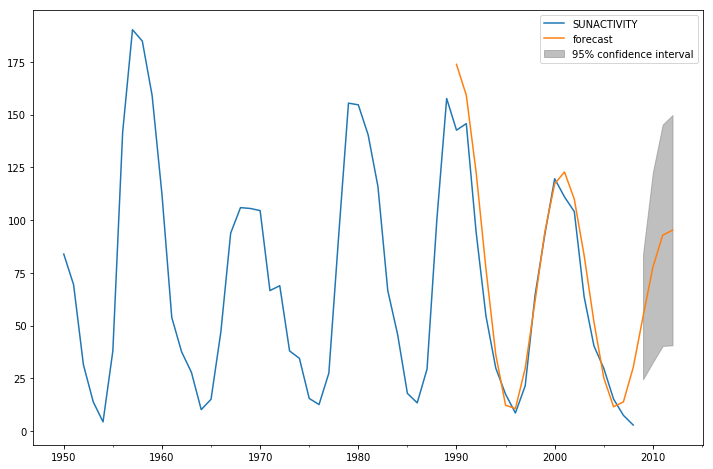

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = dta.loc['1950':].plot(ax=ax)
fig = arma_mod30.plot_predict('1990', '2012', dynamic=True, ax=ax, plot_insample=False)

#### 模型优化：
多次运行
arma_modpq = sm.tsa.ARMA(dta, (p, q)).fit(disp=True)
通过更改p， q的取值，拟合不同的模型
对于模型的arma_modpq.aic, arma_modpq.bic, arma_modpq.hqic
分别比较多个模型的AIC, BIC， 两者越小越好，循环迭代得到最优的模型。
注意：可以有多个最优解不一定只有一个模型合适

#### 循环迭代定阶，这个函数非常慢，而且也很不靠谱，对于长数据基本跑死了也拿不出p，q

In [ ]:
pmax = int(len(dta)/10) #一般阶数不超过length/10
qmax = int(len(dta)/10) #一般阶数不超过length/10
bic_matrix = [] #bic矩阵
for p in range(pmax+1):
    tmp = []
    for q in range(qmax+1):
        try: #存在部分报错，所以用try来跳过报错。
            tmp.append(sm.tsa.ARMA(dta, (p, q)).fit(disp=True).bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)

bic_matrix = pd.DataFrame(bic_matrix) #从中可以找出最小值

p,q = bic_matrix.stack().idxmin() #先用stack展平，然后用idxmin找出最小值位置。
print(u'BIC最小的p值和q值为：%s、%s' %(p,q))